<a href="https://colab.research.google.com/github/Rithvik26/Airplane_motorbike_Schooners/blob/main/Motorbikes_Airplanes_Schooner_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
zip_ref = zipfile.ZipFile("/content/drive/My Drive/archive.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [3]:
!unzip /content/drive/MyDrive/archive.zip

Archive:  /content/drive/MyDrive/archive.zip
replace caltech101_classification/Motorbikes/image_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
#importing all the required packages.
import imutils
import os
import cv2
import datetime
import numpy as np
import random

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from  tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelBinarizer

import pickle

In [5]:
#Creating variables for data,labels,imagepaths,imagepath and classes. 
data = []
labels = []
img_paths = []
img_p = "caltech101_classification"
classes = ["Motorbikes", "airplanes", "schooner"]

In [6]:
# counts number of images in each class
def classes_counter(labels, class_name):
    counter = 0
    for l in labels:
        if l == class_name:
            counter += 1
    return counter

In [7]:
#adding data to data and labels lists
for i in classes:
    l_img = [] 
    path_new = img_p+"/"+i+"/"
    print(path_new)
    
    # get the list of the available pics
    for pic in os.listdir(path_new): 
        #retrieving the pics in the folder
        if (pic.endswith(".jpg")):
            l_img.append(pic)
    
    # sort pic_path in ascending order
    l_img = sorted(l_img)  
        
    #this iterates every pic in the pics list
    for img in l_img:
        label = i
        
        pic_path = os.path.sep.join([img_p, i, img])
        pic = cv2.imread(pic_path)

        (h, w) = pic.shape[:2]
        
        # load the pic
        pic = load_img(pic_path, target_size=(128, 128))
        pic = img_to_array(pic)
        
        data.append(pic)
        labels.append(label)
        img_paths.append(pic_path)

caltech101_classification/Motorbikes/
caltech101_classification/airplanes/
caltech101_classification/schooner/


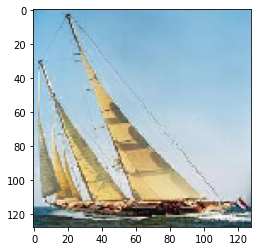

In [8]:
# Showing an example picture
imgplot = plt.imshow(pic.astype('uint8'))
plt.show()

In [9]:
#Let's check how many images are in each class.
counter_mtb = classes_counter(labels, "Motorbikes")
counter_arp = classes_counter(labels, "airplanes")
counter_sch = classes_counter(labels, "schooner")

counter_mtb, counter_arp, counter_sch

(798, 800, 63)

In [10]:
#Here we get the maximum value of number of images.
max_number = max(counter_mtb, counter_arp, counter_sch)

In [11]:
#As we can see, we don't have so much shooners, so we need to augment them. Also, I think, we'll create two more pictures of motorbikes in order to have also 800 pics. We'll do scaling and rotating.
#Function to scale the given image and return it.
def make_scale(img):
    scale_val = random.uniform(0.8, 1.2)
    imgScaled = cv2.resize(img.copy(), 
                           None, 
                           fx=scale_val, 
                           fy=scale_val)
    
    return imgScaled

In [12]:
def make_rotate(img):
    (h, w) = img.shape[:2]
    rotate_val = random.uniform(-5, 5)
    center = (w / 2, h / 2) 
    M = cv2.getRotationMatrix2D(center, 
                                rotate_val, 
                                scale=1)
    
    imgRotated = cv2.warpAffine(img.copy(), 
                                M, 
                                (w, h))
    return imgRotated

In [13]:
#Also, we need to check the number of images in each class in order to equalize number of images in each class. That's why we'll do an augmentation.
def data_a(ctr, m_x, cn):
    # while we don't have a lot of images
    while ctr < m_x:
        # loop through each image in list
        for img in data:
            if ctr < m_x:
                #Scaling is done.
                img_aug = img.copy()
                img_aug = make_scale(img_aug)
                # Saving the new image temporarily
                cv2.imwrite("img_aug.jpg", img_aug)
                # load the new image
                img_aug = load_img("img_aug.jpg", target_size=(128, 128))
                img_aug = img_to_array(img_aug)
                #removing it from the memory
                os.remove("img_aug.jpg")
                # add labels and path to images.
                data.append(img_aug)
                labels.append(cn)
                img_paths.append(img_p)
                ctr = classes_counter(labels, cn)
            else:
                break
            if ctr < m_x:
                img_aug = img.copy()
                img_aug = make_rotate(img_aug)
                # temporary save the new image
                cv2.imwrite("img_aug.jpg", img_aug)
                # load the new image
                img_aug = load_img("img_aug.jpg", target_size=(128, 128))
                img_aug = img_to_array(img_aug)
                # delete it from memory
                os.remove("img_aug.jpg")
                # add new image and it's label and path
                data.append(img_aug)
                labels.append(cn)
                img_paths.append(img_p)
                # recalculate a ctr
                ctr = classes_counter(labels, cn)
            else:
                break

In [14]:
#Let's apply the augmentation to "Motorbikes" and "schooner" classes.
data_a(counter_mtb, max_number, "Motorbikes")
data_a(counter_sch, max_number, "schooner")

In [15]:
#After augmentation
counter_mtb = classes_counter(labels, "Motorbikes")
counter_arp = classes_counter(labels, "airplanes")
counter_sch = classes_counter(labels, "schooner")

counter_mtb, counter_arp, counter_sch

(800, 800, 800)

In [16]:
# convert from the range [0, 127] to [0, 1]
data = np.array(data, dtype="float32") / 127.0

In [17]:
# convert to numpy array
labels = np.array(labels)
img_paths = np.array(img_paths)

In [18]:
# one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [19]:
if len(lb.classes_) == 2:
    print("two classes")
    labels = to_categorical(labels)

In [20]:
#we divide data to train and test sets. I decided to divide into 90% to 10% respectively.
split = train_test_split(data,
                         labels,
                         img_paths,
                         test_size=0.1,
                         random_state=42)

In [21]:
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainPaths, testPaths) = split[4:]

In [22]:
f = open("testing_multiclass.txt", "w")
f.write("\n".join(testPaths))
f.close()
d={}

In [23]:
#this is the VGG16 model that we are using which consists of 5 convolution blocks and we are going to test the performance by altering this model structure.
vgg = VGG16(weights="imagenet",
            include_top=False,
            input_tensor=Input(shape=(128, 128, 3)))

In [24]:
#freezing all the layers inorder to train them
vgg.trainable = False

In [25]:
#model-1 with 1 convolution block
layer_dict = dict([(layer.name, layer) for layer in vgg.layers])
outputa = layer_dict['block1_pool'].output
m1 = Model(inputs=vgg.input, outputs=outputa)



# flatten the max-pooling 
# output of VGG
flatten = m1.output
flatten = Flatten()(flatten)

#And for class prediction (classification task) we'll use a softmax activation function.
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), 
                    activation="softmax", 
                    name="class_label")(softmaxHead)


In [26]:
m1 = Model(
    inputs=m1.input,
    outputs=(softmaxHead))

In [27]:
# we need to define some hyperparameters (learning rate, number of epochs, size of batch).
lr = 0.0001
epochs = 20
batch_size = 32

In [28]:
losses = {
    "class_label": "categorical_crossentropy",
}

In [29]:
trainTargets = {
    "class_label": trainLabels,
}

In [30]:
testTargets = {
    "class_label": testLabels,
}

In [31]:
model_path = "model1.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [32]:
opt = Adam(lr)
m1.compile(loss=losses, 
              optimizer=opt, 
              metrics=["accuracy"])

print(m1.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dense (Dense)               (None, 512)               134218240 
                                                                 
 dropout (Dropout)           (None, 512)               0   

In [33]:
H1 = m1.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[model_checkpoint_callback],
    verbose=1)

Epoch 1/20
68/68 [==============================] - 14s 159ms/step - loss: 39.5938 - accuracy: 0.6630 - val_loss: 3.2267 - val_accuracy: 0.6833
Epoch 2/20
68/68 [==============================] - 10s 144ms/step - loss: 0.7991 - accuracy: 0.7889 - val_loss: 0.3358 - val_accuracy: 0.8625
Epoch 3/20
68/68 [==============================] - 3s 47ms/step - loss: 0.5130 - accuracy: 0.7556 - val_loss: 0.3230 - val_accuracy: 0.8167
Epoch 4/20
68/68 [==============================] - 3s 49ms/step - loss: 0.4357 - accuracy: 0.7838 - val_loss: 0.3827 - val_accuracy: 0.8250
Epoch 5/20
68/68 [==============================] - 3s 46ms/step - loss: 0.6419 - accuracy: 0.7764 - val_loss: 0.4432 - val_accuracy: 0.8042
Epoch 6/20
68/68 [==============================] - 3s 48ms/step - loss: 0.4519 - accuracy: 0.7606 - val_loss: 0.3238 - val_accuracy: 0.8583
Epoch 7/20
68/68 [==============================] - 3s 47ms/step - loss: 0.4553 - accuracy: 0.7495 - val_loss: 0.3962 - val_accuracy: 0.7958
Epoch 8/

In [34]:
def train_loss_graph(mod):
    lossNames = ["loss"]
    P = np.arange(0, epochs)
    plt.style.use("ggplot")
    plt.figure(figsize=(17, 10))
    plt.title("Train Loss & Val Loss")
    plt.xlabel("Epoch No")
    plt.ylabel("Loss")
    plt.plot(P, mod.history["loss"], label="loss")
    plt.plot(P, mod.history["val_loss"], label="val_loss")
    plt.legend()

    plt.show()

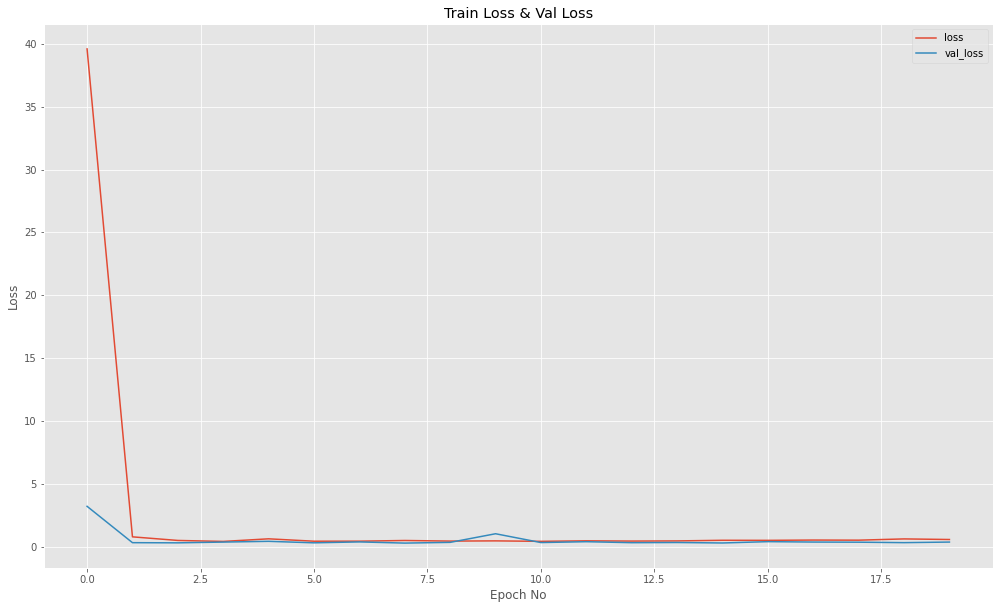

In [35]:
train_loss_graph(H1)

In [36]:
def accuracy_plot(mod):
    ln = ["loss"]
    P = np.arange(0, epochs)
    plt.style.use("ggplot")
    plt.figure(figsize=(17, 10))
    plt.style.use("ggplot")
    plt.figure(figsize=(17, 10))

    plt.plot(P, mod.history["accuracy"], label="acc")
    plt.plot(P, mod.history["val_accuracy"], label="val_acc")

    plt.title("Train Accuracy & Val Accuracy")
    plt.xlabel("Epoch No")
    plt.ylabel("Accuracy")
    plt.legend()

In [37]:
d["m1"]=H1.history["val_accuracy"][-1]

<Figure size 1224x720 with 0 Axes>

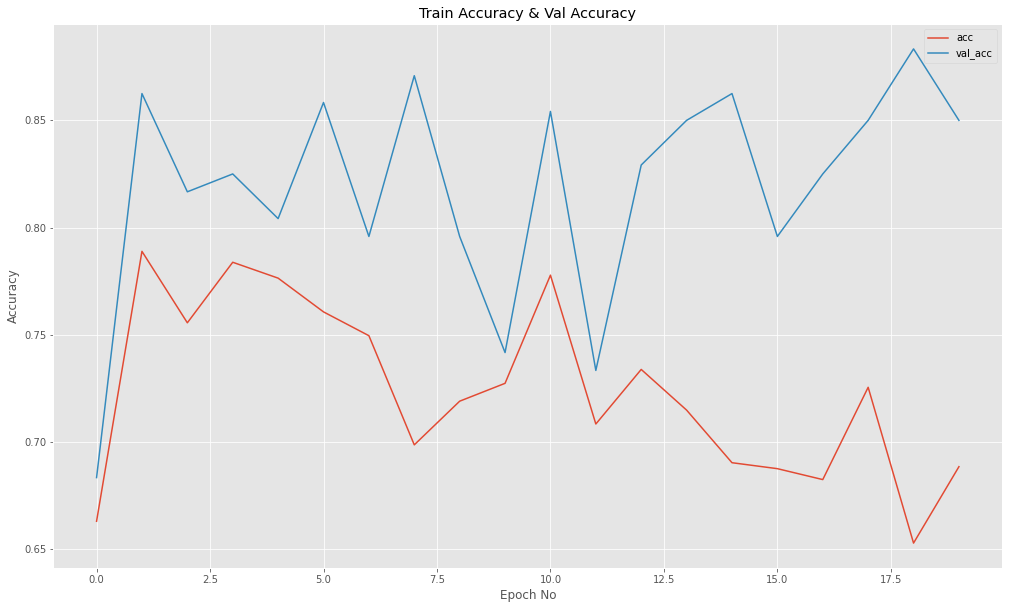

In [38]:
accuracy_plot(H1)


In [39]:
#model-2 till 2nd convolution block
outputa = layer_dict['block2_pool'].output
m2 = Model(inputs=vgg.input, outputs=outputa)


In [40]:
flatten = m2.output
flatten = Flatten()(flatten)
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)

softmaxHead = Dense(len(lb.classes_), 
                    activation="softmax", 
                    name="class_label")(softmaxHead)

In [41]:

m2 = Model(
    inputs=m2.input,
    outputs=(softmaxHead))

In [42]:
opt = Adam(lr)

m2.compile(loss=losses, 
              optimizer=opt, 
              metrics=["accuracy"])

print(m2.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [43]:

model_path = "model2.h5"

model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [44]:
H2 = m2.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[model_checkpoint_callback],
    verbose=1)

Epoch 1/20
68/68 [==============================] - 8s 98ms/step - loss: 31.5014 - accuracy: 0.7069 - val_loss: 3.7598 - val_accuracy: 0.8375
Epoch 2/20
68/68 [==============================] - 6s 90ms/step - loss: 1.5482 - accuracy: 0.8657 - val_loss: 0.3710 - val_accuracy: 0.8875
Epoch 3/20
68/68 [==============================] - 6s 93ms/step - loss: 0.4806 - accuracy: 0.8764 - val_loss: 0.2136 - val_accuracy: 0.9167
Epoch 4/20
68/68 [==============================] - 6s 93ms/step - loss: 0.2901 - accuracy: 0.8718 - val_loss: 0.1783 - val_accuracy: 0.9208
Epoch 5/20
68/68 [==============================] - 3s 46ms/step - loss: 0.2756 - accuracy: 0.8755 - val_loss: 0.2972 - val_accuracy: 0.9042
Epoch 6/20
68/68 [==============================] - 3s 44ms/step - loss: 0.2507 - accuracy: 0.8866 - val_loss: 0.1871 - val_accuracy: 0.9083
Epoch 7/20
68/68 [==============================] - 3s 45ms/step - loss: 0.2385 - accuracy: 0.9097 - val_loss: 0.1910 - val_accuracy: 0.9125
Epoch 8/20
6

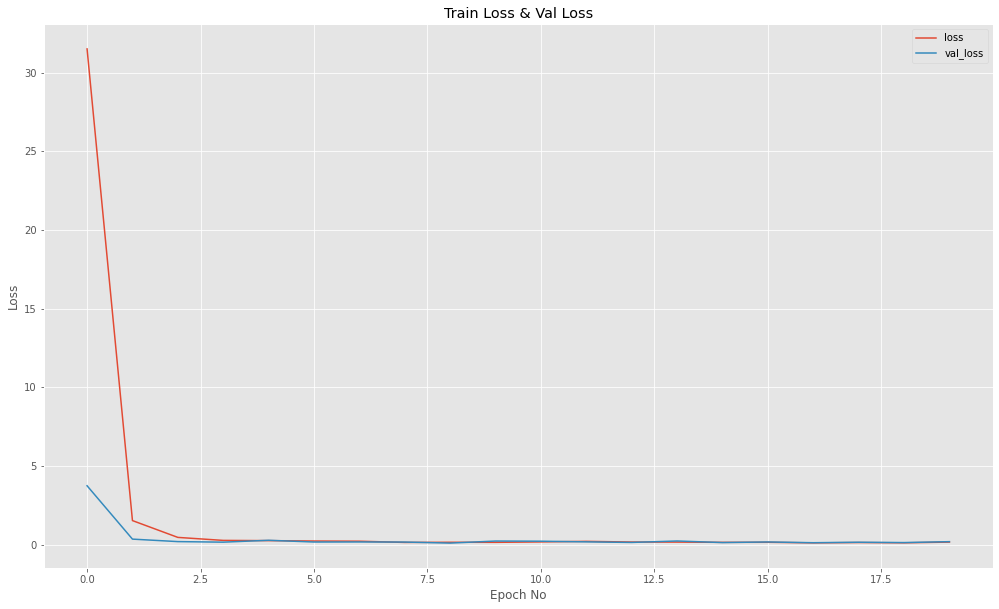

In [45]:
train_loss_graph(H2)

<Figure size 1224x720 with 0 Axes>

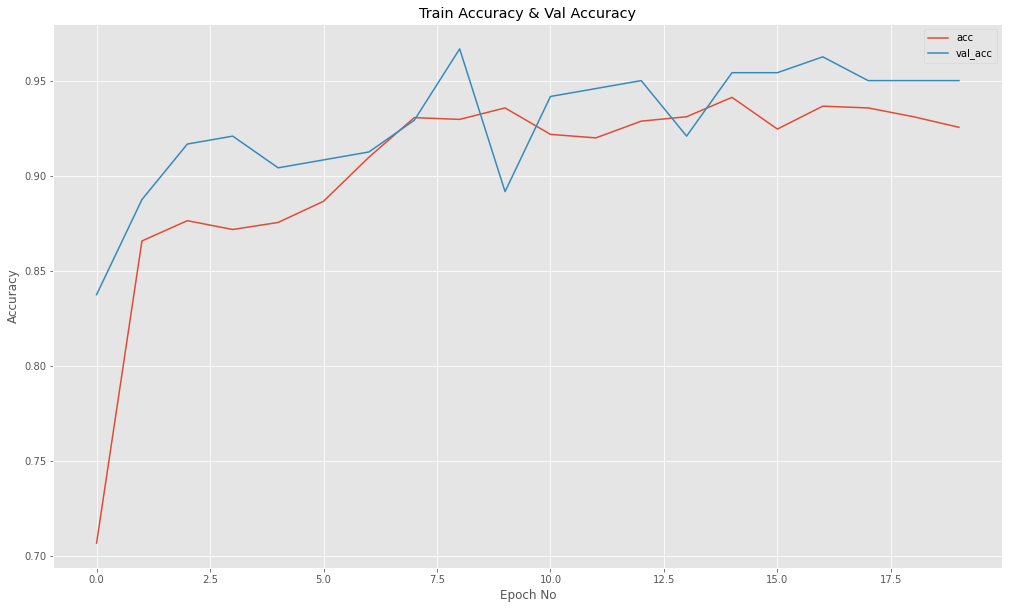

In [46]:
accuracy_plot(H2)

In [47]:
d["m2"]=H2.history["val_accuracy"][-1]

In [48]:
#model-3 with 5 convolution block

m3 = Model(inputs=vgg.input, outputs=vgg.output)

flatten = m3.output
flatten = Flatten()(flatten)
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), 
                    activation="softmax", 
                    name="class_label")(softmaxHead)

In [49]:
m3 = Model(
    inputs=m3.input,
    outputs=(softmaxHead))

In [50]:
opt = Adam(lr)

m3.compile(loss=losses, 
              optimizer=opt, 
              metrics=["accuracy"])

print(m3.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [51]:
model_path = "model3.h5"

model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [52]:
H3 = m3.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[model_checkpoint_callback],
    verbose=1)

Epoch 1/20
68/68 [==============================] - 6s 73ms/step - loss: 0.4669 - accuracy: 0.7861 - val_loss: 0.2638 - val_accuracy: 0.8958
Epoch 2/20
68/68 [==============================] - 4s 63ms/step - loss: 0.2527 - accuracy: 0.8954 - val_loss: 0.2236 - val_accuracy: 0.9167
Epoch 3/20
68/68 [==============================] - 4s 63ms/step - loss: 0.1858 - accuracy: 0.9292 - val_loss: 0.1944 - val_accuracy: 0.9250
Epoch 4/20
68/68 [==============================] - 4s 59ms/step - loss: 0.1552 - accuracy: 0.9375 - val_loss: 0.1929 - val_accuracy: 0.9208
Epoch 5/20
68/68 [==============================] - 4s 59ms/step - loss: 0.1300 - accuracy: 0.9542 - val_loss: 0.1862 - val_accuracy: 0.9208
Epoch 6/20
68/68 [==============================] - 4s 60ms/step - loss: 0.1159 - accuracy: 0.9625 - val_loss: 0.1882 - val_accuracy: 0.9208
Epoch 7/20
68/68 [==============================] - 4s 60ms/step - loss: 0.0955 - accuracy: 0.9662 - val_loss: 0.1908 - val_accuracy: 0.9208
Epoch 8/20
68

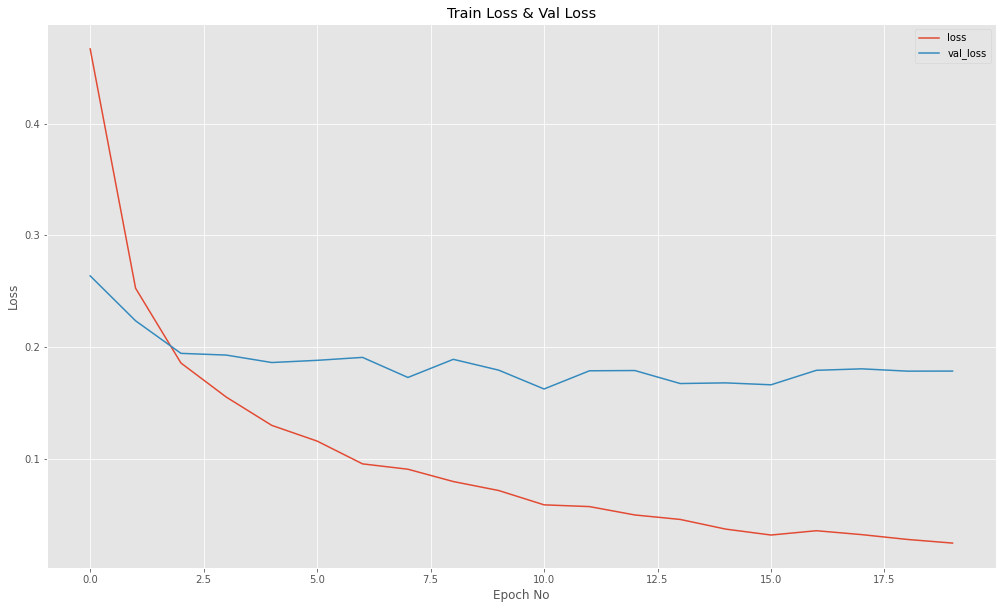

In [53]:
train_loss_graph(H3)

<Figure size 1224x720 with 0 Axes>

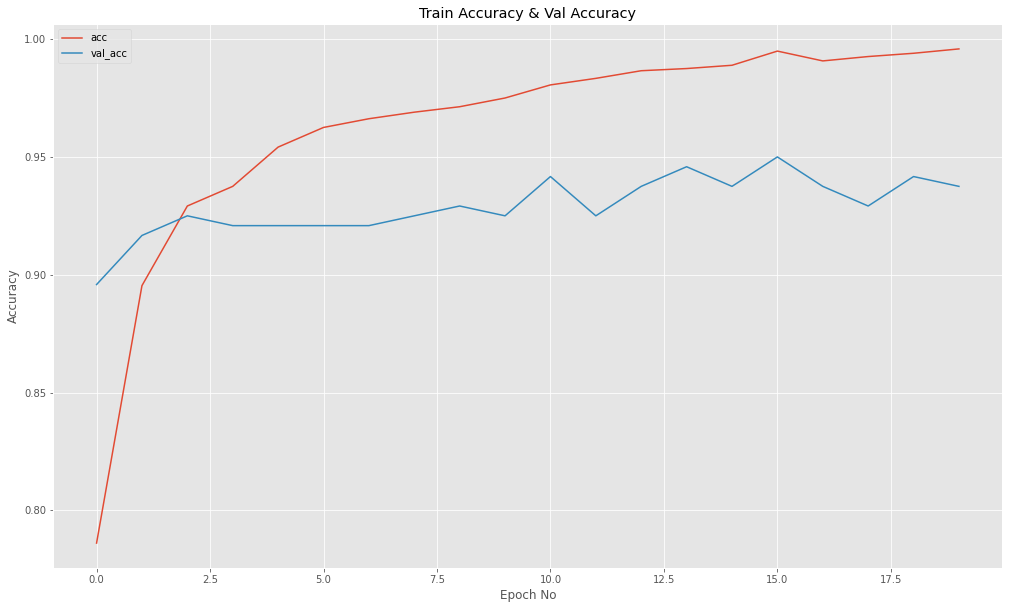

In [54]:
accuracy_plot(H3)

In [55]:
d["m3"]=H3.history["val_accuracy"][-1]

In [56]:
#model-4
outputa = layer_dict['block3_pool'].output
m4 = Model(inputs=vgg.input, outputs=outputa)

flatten = m4.output
flatten = Flatten()(flatten)
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), 
                    activation="softmax", 
                    name="class_label")(softmaxHead)

In [57]:
m4 = Model(
    inputs=m4.input,
    outputs=(softmaxHead))

In [58]:
opt = Adam(lr)

m4.compile(loss=losses, 
              optimizer=opt, 
              metrics=["accuracy"])

print(m4.summary())

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [59]:
model_path = "model4.h5"

model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [60]:
H4 = m4.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=16,
    epochs=epochs,
    callbacks=[model_checkpoint_callback],
    verbose=1)

Epoch 1/20
135/135 [==============================] - 6s 41ms/step - loss: 16.1767 - accuracy: 0.8056 - val_loss: 4.1035 - val_accuracy: 0.8375
Epoch 2/20
135/135 [==============================] - 5s 38ms/step - loss: 2.4984 - accuracy: 0.8912 - val_loss: 0.7164 - val_accuracy: 0.9042
Epoch 3/20
135/135 [==============================] - 5s 39ms/step - loss: 0.6516 - accuracy: 0.9157 - val_loss: 0.2744 - val_accuracy: 0.9375
Epoch 4/20
135/135 [==============================] - 4s 29ms/step - loss: 0.3736 - accuracy: 0.9343 - val_loss: 0.2335 - val_accuracy: 0.9292
Epoch 5/20
135/135 [==============================] - 5s 38ms/step - loss: 0.2541 - accuracy: 0.9352 - val_loss: 0.2633 - val_accuracy: 0.9583
Epoch 6/20
135/135 [==============================] - 4s 29ms/step - loss: 0.1963 - accuracy: 0.9384 - val_loss: 0.1591 - val_accuracy: 0.9542
Epoch 7/20
135/135 [==============================] - 4s 29ms/step - loss: 0.1995 - accuracy: 0.9495 - val_loss: 0.1716 - val_accuracy: 0.958

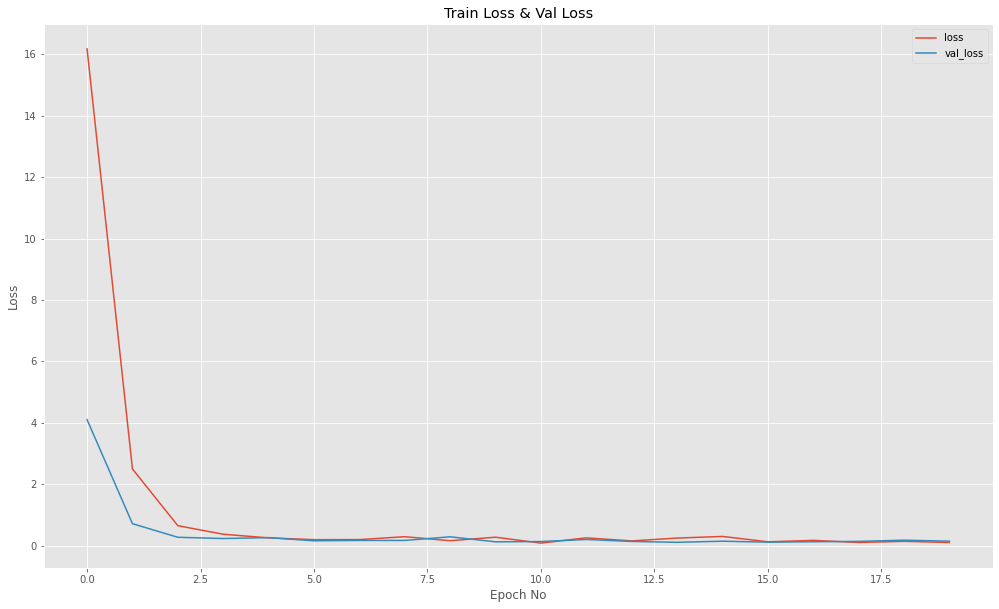

In [61]:
train_loss_graph(H4)

<Figure size 1224x720 with 0 Axes>

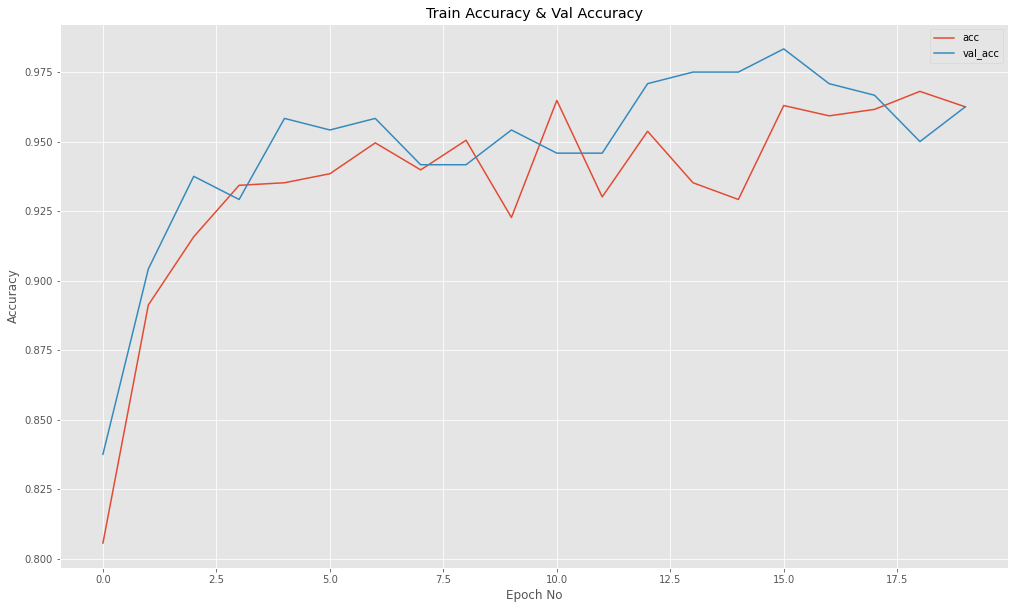

In [62]:
accuracy_plot(H4)

In [63]:
d["m4"]=H4.history["val_accuracy"][-1]

In [64]:
#model-5
outputa = layer_dict['block3_pool'].output
m5 = Model(inputs=vgg.input, outputs=outputa)

flatten = m5.output
flatten = Flatten()(flatten)
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), 
                    activation="softmax", 
                    name="class_label")(softmaxHead)

In [65]:
m5 = Model(
    inputs=m5.input,
    outputs=(softmaxHead))

In [66]:
opt = Adam(lr)

m5.compile(loss=losses, 
              optimizer=opt, 
              metrics=["accuracy"])

print(m5.summary())

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [67]:
model_path = "model5.h5"

model_checkpoint_callback = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [68]:
H5 = m5.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=8,
    epochs=epochs,
    callbacks=[model_checkpoint_callback],
    verbose=1)

Epoch 1/20
270/270 [==============================] - 8s 27ms/step - loss: 12.7165 - accuracy: 0.8014 - val_loss: 1.9510 - val_accuracy: 0.8958
Epoch 2/20
270/270 [==============================] - 6s 21ms/step - loss: 1.1130 - accuracy: 0.8731 - val_loss: 0.7577 - val_accuracy: 0.8625
Epoch 3/20
270/270 [==============================] - 7s 26ms/step - loss: 0.5376 - accuracy: 0.8898 - val_loss: 0.5009 - val_accuracy: 0.9042
Epoch 4/20
270/270 [==============================] - 6s 21ms/step - loss: 0.3873 - accuracy: 0.8968 - val_loss: 0.3789 - val_accuracy: 0.8375
Epoch 5/20
270/270 [==============================] - 6s 22ms/step - loss: 0.3380 - accuracy: 0.8958 - val_loss: 0.8016 - val_accuracy: 0.8500
Epoch 6/20
270/270 [==============================] - 7s 26ms/step - loss: 0.3030 - accuracy: 0.9102 - val_loss: 0.1633 - val_accuracy: 0.9583
Epoch 7/20
270/270 [==============================] - 6s 22ms/step - loss: 0.1878 - accuracy: 0.9343 - val_loss: 0.3174 - val_accuracy: 0.954

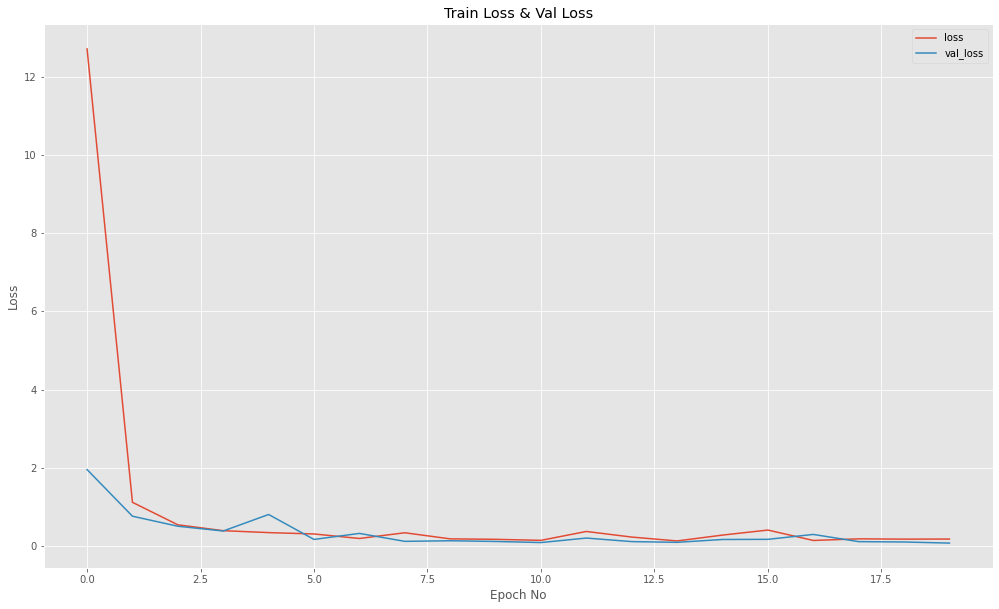

In [69]:
train_loss_graph(H5)

<Figure size 1224x720 with 0 Axes>

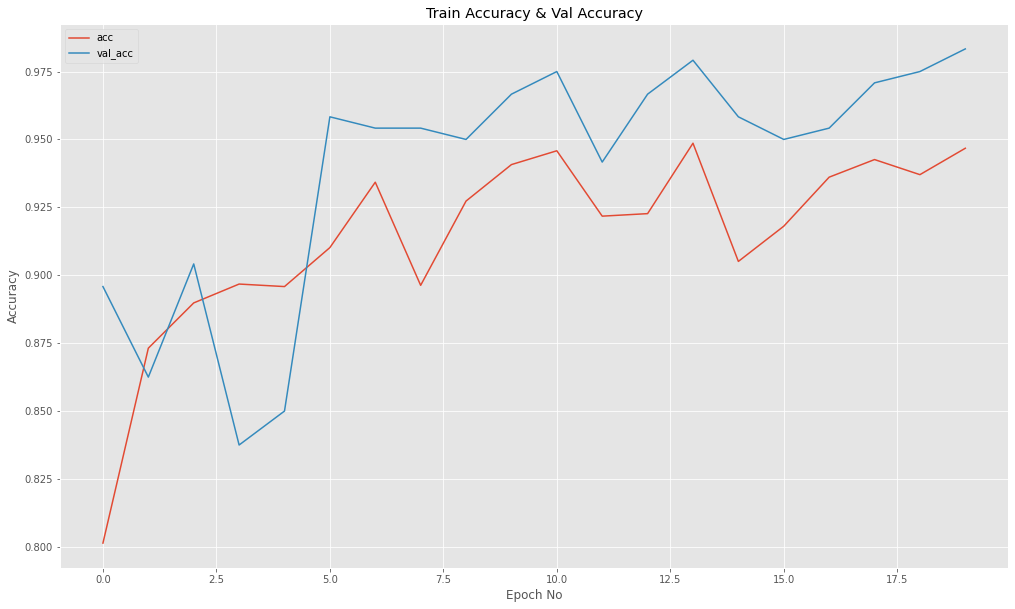

In [70]:
accuracy_plot(H5)

In [71]:
d["m5"]=H5.history["val_accuracy"][-1]

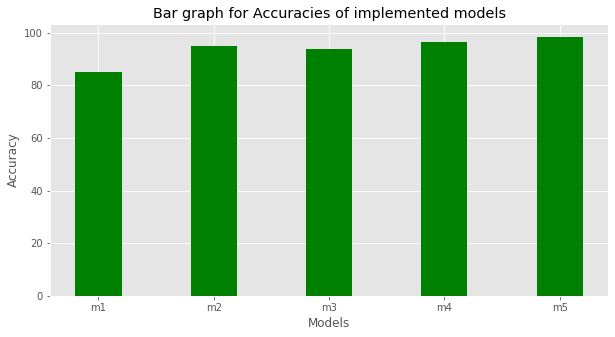

In [73]:

models = list(d.keys())
accuracies = [100*i for i in d.values()]
  
fig = plt.figure(figsize = (10, 5))
plt.bar(models, accuracies, color ='green',
        width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Bar graph for Accuracies of implemented models")
plt.show()